In [2]:


import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.1.0+cpu
Is CUDA enabled? False


W ćwiczeniu 6 należy zbudować sieć wykorzystującą warstwy CNN i operator max
pooling. Warstwa CNN dostępna jest w torch.nn. Conv2d:
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
Warstwa przyjmuje 4-wymiarowe wejścia (batch, kanały obrazka, wysokość,
szerokość). Dla obrazków czarno-białych liczba kanałów wejścia będzie równa 1,
liczba kanałów wyjściowych powinna być większa. Po przejściu przez jedną lub więcej
warstw konwolucyjnych, wyjście trzeba spłaszczyć i podać do warstwy liniowej, dalej
skorzystać ze standardowej dla klasyfikacji funkcji kosztu.
Do implementacji warstwy liniowej można skorzystać z LazyLinear, która
automatycznie ustala wymiarowość przy pierwszym przejściu danych.
Do przebadania będzie
• Liczba kanałów wyjściowych warstwy konwolucyjnej
• Rozmiar filtra warstwy konwolucyjnej
• Rozmiar okna poolingu
• Zaburzenia danych: dane można zaburzyć dodając do wejściowego batcha
batch o tych samych wymiarach, wygenerowany jako szum gaussowski o
różnych odchyleniach. Przebadać scenariusze: szum dodany w danych
testowych vs szum dodany zarówno w testowych, jak i treningowych.
Ćwiczenie oceniane jest w skali 0-10 pkt, na jego wykonanie są 2 tygodnie.

In [3]:
import time
from torchvision import transforms, datasets
import torch
from torch.utils.data import Subset
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import random
from sklearn.metrics import precision_score, accuracy_score, f1_score
from torchvision.transforms import GaussianBlur

default_batch_size = 500
default_batch_size_10 = 128
default_batch_size_1 = 64

big_batch_size = 512

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])

transform_blur = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    GaussianBlur(kernel_size=9, sigma=(1.5, 5.0))
])

#how to get train and test data
train_data = datasets.FashionMNIST('path', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('path', download=True, train=False, transform=transform)

train_data_noise = datasets.FashionMNIST('path', download=True, train=True, transform=transform_blur)
test_data_noise = datasets.FashionMNIST('path', download=True, train=False, transform=transform_blur)

train_indices = list(range(len(train_data)))
random.shuffle(train_indices)
train_indices_10_percent = train_indices[:len(train_indices)//10]
train_indices_1_percent = train_indices[:len(train_indices)//100]

test_indices = list(range(len(test_data)))
random.shuffle(test_indices)
test_indices_10_percent = test_indices[:len(test_indices)//10]
test_indices_1_percent = test_indices[:len(test_indices)//100]

train_data_10_percent = Subset(train_data, train_indices_10_percent)
test_data_10_percent = Subset(test_data, test_indices_10_percent)

train_data_1_percent = Subset(train_data, train_indices_1_percent)
test_data_1_percent = Subset(test_data, test_indices_1_percent)

train_data_10_percent_noisy = Subset(train_data_noise, train_indices_10_percent)
test_data_10_percent_noisy = Subset(test_data_noise, test_indices_10_percent)

print('100%: ',len(train_data))
print('100%: ',len(test_data))
print('10%: ',len(train_data_10_percent))
print('10%: ',len(test_data_10_percent))
print('1%: ',len(train_data_1_percent))
print('1%: ',len(test_data_1_percent))
# print out rest of configuration
print('Default batch size: ',default_batch_size)
print('Big batch size: ',big_batch_size)

#Define a dataloader to load data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=default_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=default_batch_size, shuffle=True)

train_loader_10 = torch.utils.data.DataLoader(train_data_10_percent, batch_size=default_batch_size_10, shuffle=True)
test_loader_10 = torch.utils.data.DataLoader(test_data_10_percent, batch_size=default_batch_size_10, shuffle=True)

train_loader_1 = torch.utils.data.DataLoader(train_data_1_percent, batch_size=default_batch_size_1, shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_data_1_percent, batch_size=default_batch_size_1, shuffle=True)

train_loader_big_batch = torch.utils.data.DataLoader(train_data_10_percent, batch_size=big_batch_size, shuffle=True)
test_loader_big_batch = torch.utils.data.DataLoader(test_data_10_percent, batch_size=big_batch_size, shuffle=True)

#add gausian blur to 10% of train data make a subset




train_data_10_percent_noisy_loader = torch.utils.data.DataLoader(train_data_10_percent_noisy, batch_size=default_batch_size_10, shuffle=True)
test_data_10_percent_noisy_loader = torch.utils.data.DataLoader(test_data_10_percent_noisy, batch_size=default_batch_size_10, shuffle=True)

print('10%:' ,len(train_loader_10))
print('10%:' ,len(test_loader_10))


print('10% noisy: ',len(train_data_10_percent_noisy_loader))
print('10% noisy: ',len(test_data_10_percent_noisy_loader))

def train(model, criterion, data_loader, test_loader, epochs):
    #reset model
    model.apply(init_normal)
    optimizer = optim.Adam(model.parameters())
    torch.manual_seed(seed)

    start_timestamp = time.time()
    training_loss = []
    test_loss_list = []
    for epoch in range(epochs):
        running_loss = 0
        test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 1, 28, 28)
                logits = model(images)
                loss_test = criterion(logits, labels)
                test_loss += loss_test.item()

        for images, labels in data_loader:
            images = images.view(-1, 1, 28, 28)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        running_loss = running_loss/len(data_loader)
        test_loss = test_loss/len(test_loader)
        training_loss.append(running_loss) 
        test_loss_list.append(test_loss)

        if (epoch) % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Train Loss: {running_loss:.4f}, Test Loss: {test_loss:.4f}")

    print(f"\nTraining Time (in seconds) = {(time.time()-start_timestamp):.2f}")
    return training_loss, test_loss_list

def plot_loss(losses, title):
    train, test = losses
    plt.plot(train)
    plt.plot(test)
    plt.legend(['Train' ,'Test'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 3)
    plt.show()



# Define the network architecture
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # dim 28x28
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # dim 14x14
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # dim 14x14
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # dim 7x7
    nn.Dropout2d(0.3),
    # nn.BatchNorm2d(64),
    nn.Flatten(),  # dim [1,]
    nn.BatchNorm1d(64*7*7),
    nn.Linear(64*7*7, 256),
    nn.Dropout(0.25),
    nn.LeakyReLU(),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)

oneLayerModel_big_batch = nn.Sequential(
                    nn.Linear(784, 16),
                    nn.LeakyReLU(),
                    nn.Linear(16, 10),
                    nn.LogSoftmax(dim = 1))

oneLayerModel_less_neurons = nn.Sequential(
                      nn.Linear(784, 8),
                      nn.LeakyReLU(),
                      nn.Linear(8, 10),
                      nn.LogSoftmax(dim = 1))


#two layer model
twoLayerModel = nn.Sequential(
                    nn.Linear(784, 16),
                    nn.LeakyReLU(),
                    nn.Linear(16, 8),
                    nn.LeakyReLU(),
                    nn.Linear(8, 10),
                    nn.LogSoftmax(dim = 1))

twoLayerModel_big_batch = nn.Sequential(
                    nn.Linear(784, 16),
                    nn.LeakyReLU(),
                    nn.Linear(16, 8),
                    nn.LeakyReLU(),
                    nn.Linear(8, 10),
                    nn.LogSoftmax(dim = 1))

twoLayerModel_less_neurons = nn.Sequential(
                        nn.Linear(784, 8),
                        nn.LeakyReLU(),
                        nn.Linear(8, 4),
                        nn.LeakyReLU(),
                        nn.Linear(4, 10),
                        nn.LogSoftmax(dim = 1))


def init_normal(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(seed)
        init.xavier_normal_(m.weight)
        init.constant_(m.bias, 0)

# Initialize the weights
model.apply(init_normal)
oneLayerModel_less_neurons.apply(init_normal)
oneLayerModel_big_batch.apply(init_normal)
twoLayerModel.apply(init_normal)
twoLayerModel_big_batch.apply(init_normal)
twoLayerModel_less_neurons.apply(init_normal)

# Define the loss
criterion = nn.NLLLoss();


epochs = 100

def evaluate_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')



100%:  60000
100%:  10000
10%:  6000
10%:  1000
1%:  600
1%:  100
Default batch size:  500
Big batch size:  512
10%: 47
10%: 8
10% noisy:  47
10% noisy:  8


oneLayerModel 10%
Epoch 0/100 - Train Loss: 0.9221, Test Loss: 3.2642
Epoch 10/100 - Train Loss: 0.1996, Test Loss: 0.5457
Epoch 20/100 - Train Loss: 0.0972, Test Loss: 0.5586
Epoch 30/100 - Train Loss: 0.0565, Test Loss: 0.6074
Epoch 40/100 - Train Loss: 0.0375, Test Loss: 0.5951
Epoch 50/100 - Train Loss: 0.0353, Test Loss: 0.7394
Epoch 60/100 - Train Loss: 0.0265, Test Loss: 0.8405
Epoch 70/100 - Train Loss: 0.0373, Test Loss: 0.8111
Epoch 80/100 - Train Loss: 0.0228, Test Loss: 0.8305
Epoch 90/100 - Train Loss: 0.0187, Test Loss: 0.8975

Training Time (in seconds) = 1772.63
Accuracy: 0.8870
Precision: 0.8865
F1 Score: 0.8858


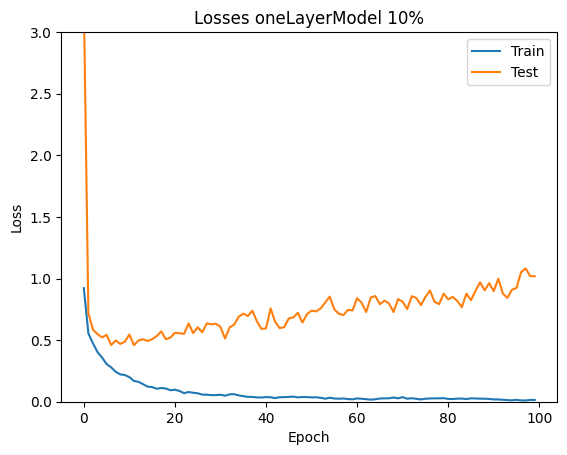

In [4]:

# print('oneLayerModel 100%')
# oneLayerModel_losses = train(
#     model, 
#     criterion, 
#     train_loader, 
#     test_loader, 
#     epochs=10)
# evaluate_model(model, test_loader)
# plot_loss(oneLayerModel_losses, 'Losses oneLayerModel 100%')

# print('oneLayerModel_less_neurons 100%')
# oneLayerModel_less_neurons_losses = train(
#     oneLayerModel_less_neurons, 
#     criterion, 
#     train_loader, 
#     test_loader, 
#     epochs=10)
# evaluate_model(oneLayerModel_less_neurons, test_loader)
# plot_loss(oneLayerModel_less_neurons_losses, 'Losses oneLayerModel_less_neurons 100%')

# print('twoLayerModel 100%')
# twoLayerModel_losses = train(
#     twoLayerModel,
#     criterion,
#     train_loader,
#     test_loader,
#     epochs=10)
# evaluate_model(twoLayerModel, test_loader)
# plot_loss(twoLayerModel_losses, 'Losses twoLayerModel 100%')

# print('twoLayerModel_less_neurons 100%')
# twoLayerModel_less_neurons_losses = train(
#     twoLayerModel_less_neurons, 
#     criterion, 
#     train_loader, 
#     test_loader, 
#     epochs=10)
# evaluate_model(twoLayerModel_less_neurons, test_loader)
# plot_loss(twoLayerModel_less_neurons_losses, 'Losses twoLayerModel_less_neurons 100%')

# #-----------------10%-----------------

print('oneLayerModel 10%')
oneLayerModel_losses_10 = train(
    model,
    criterion,
    train_loader_10,
    test_loader_10,
    epochs=epochs)
evaluate_model(model, test_loader_10)
plot_loss(oneLayerModel_losses_10, 'Losses oneLayerModel 10%')

# print('oneLayerModel_big_batch 10%')
# oneLayerModel_losses_big_batch = train(
#     oneLayerModel_big_batch, 
#     criterion, 
#     train_loader_big_batch, 
#     test_loader_big_batch, 
#     epochs=epochs)
# evaluate_model(oneLayerModel_big_batch, test_loader_big_batch)
# plot_loss(oneLayerModel_losses_big_batch, 'Losses oneLayerModel_big_batch 10%')

# print('oneLayerModel_less_neurons 10%')
# oneLayerModel_less_neurons_losses = train(
#     oneLayerModel_less_neurons,
#     criterion,
#     train_loader_10,
#     test_loader_10,
#     epochs=epochs)
# evaluate_model(oneLayerModel_less_neurons, test_loader_10)
# plot_loss(oneLayerModel_less_neurons_losses, 'Losses oneLayerModel_less_neurons 10%')

# print('twoLayerModel 10%')
# twoLayerModel_losses = train(
#     twoLayerModel, 
#     criterion, 
#     train_loader_10, 
#     test_loader_10, 
#     epochs=epochs)
# evaluate_model(twoLayerModel, test_loader_10)
# plot_loss(twoLayerModel_losses, 'Losses twoLayerModel 10%')

# print('twoLayerModel_big_batch 10%')
# twoLayerModel_losses_big_batch = train(
#     twoLayerModel_big_batch, 
#     criterion, 
#     train_loader_big_batch, 
#     test_loader_big_batch, 
#     epochs=epochs)
# evaluate_model(twoLayerModel_big_batch, test_loader_big_batch)

# plot_loss(twoLayerModel_losses_big_batch, 'Losses twoLayerModel_big_batch 10%')


# print('twoLayerModel_less_neurons 10%')
# twoLayerModel_less_neurons_losses = train(
#     twoLayerModel_less_neurons, 
#     criterion, 
#     train_loader_10, 
#     test_loader_10, 
#     epochs=epochs)
# evaluate_model(twoLayerModel_less_neurons, test_loader_10)

# plot_loss(twoLayerModel_less_neurons_losses, 'Losses twoLayerModel_less_neurons 10%')

# #-----------------1%-----------------

# print('oneLayerModel 1%')
# oneLayerModel_losses_1 = train(
#     oneLayerModel, 
#     criterion, 
#     train_loader_1, 
#     test_loader_1, 
#     epochs=epochs)
# evaluate_model(oneLayerModel, test_loader_1)
# plot_loss(oneLayerModel_losses_1, 'Losses oneLayerModel_1%')

# print('twoLayerModel 1%')
# #train model
# twoLayerModel_losses_1 = train(
#     twoLayerModel, 
#     criterion, 
#     train_loader_1, 
#     test_loader_1, 
#     epochs=epochs)

# evaluate_model(twoLayerModel, test_loader_1)
# plot_loss(twoLayerModel_losses_1, 'Losses twoLayerModel_1%')


#-----------------10% noisy-----------------



# print('oneLayerModel_10%_noisy_test')
# oneLayerModel_losses_10_noisy = train(
#     oneLayerModel, 
#     criterion, 
#     train_loader_10, 
#     test_data_10_percent_noisy_loader, 
#     epochs=epochs)
# evaluate_model(oneLayerModel, test_data_10_percent_noisy_loader)
# plot_loss(oneLayerModel_losses_10_noisy, 'Losses oneLayerModel_10%_noisy_test')



# print('oneLayerModel_10%_noisy_test_and_train')
# oneLayerModel_losses_10_noisy = train(
#     oneLayerModel, 
#     criterion, 
#     train_data_10_percent_noisy_loader, 
#     test_data_10_percent_noisy_loader, 
#     epochs=epochs)

# evaluate_model(oneLayerModel, test_data_10_percent_noisy_loader)
# plot_loss(oneLayerModel_losses_10_noisy, 'Losses oneLayerModel_10%_noisy_test_and_train')

# print('twoLayerModel_10%_noisy_test')
# twoLayerModel_losses_10_noisy = train(
#     twoLayerModel, 
#     criterion, 
#     train_loader_10, 
#     test_data_10_percent_noisy_loader, 
#     epochs=epochs)
# evaluate_model(twoLayerModel, test_data_10_percent_noisy_loader)
# plot_loss(twoLayerModel_losses_10_noisy, 'Losses twoLayerModel_10%_noisy_test')

# print('twoLayerModel_10%_noisy_test_and_train')
# twoLayerModel_losses_10_noisy = train(
#     twoLayerModel, 
#     criterion, 
#     train_data_10_percent_noisy_loader, 
#     test_data_10_percent_noisy_loader, 
#     epochs=epochs)
# evaluate_model(twoLayerModel, test_data_10_percent_noisy_loader)
# plot_loss(twoLayerModel_losses_10_noisy, 'Losses twoLayerModel_10%_noisy_test_and_train')








In [8]:
import time
from torchvision import transforms, datasets
import torch
from torch.utils.data import Subset
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import random
from sklearn.metrics import precision_score, accuracy_score, f1_score
from torchvision.transforms import GaussianBlur
from torch.autograd import Variable

default_batch_size = 100

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])

transform_blur = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    GaussianBlur(kernel_size=9, sigma=(1.5, 5.0))
])

#how to get train and test data
train_data = datasets.FashionMNIST('path', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('path', download=True, train=False, transform=transform)

# use only 5% of train data
train_indices = list(range(len(train_data)))
random.shuffle(train_indices)
train_indices_5_percent = train_indices[:len(train_indices)//20]

test_indices = list(range(len(test_data)))
random.shuffle(test_indices)
test_indices_5_percent = test_indices[:len(test_indices)//20]
# dont use subset for now
train_data_5_percent = Subset(train_data, train_indices_5_percent)
test_data_5_percent = Subset(test_data, test_indices_5_percent)

print('100%: ',len(train_data))
print('100%: ',len(test_data))
print('5%: ',len(train_data_5_percent))
print('5%: ',len(test_data_5_percent))
# print out rest of configuration



train_loader = torch.utils.data.DataLoader(train_data_5_percent, batch_size=default_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_5_percent, batch_size=default_batch_size, shuffle=True)


def train(model, criterion, data_loader, test_loader, epochs):
    #reset model
    model.apply(init_normal)
    optimizer = optim.Adam(model.parameters())
    torch.manual_seed(seed)

    start_timestamp = time.time()
    training_loss = []
    test_loss_list = []

    for epoch in range(epochs):
        running_loss = 0
        test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = Variable(images.view(-1, 1, 28, 28))
                labels = Variable(labels)
                #forward pass
                logits = model(images)
                loss_test = criterion(logits, labels)
                test_loss += loss_test.item()

        for images, labels in data_loader:
            images = Variable(images.view(-1, 1, 28, 28))
            labels = Variable(labels)
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        running_loss = running_loss/len(data_loader)
        test_loss = test_loss/len(test_loader)
        training_loss.append(running_loss) 
        test_loss_list.append(test_loss)

        if (epoch) % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Train Loss: {running_loss:.4f}, Test Loss: {test_loss:.4f}")

    print(f"\nTraining Time (in seconds) = {(time.time()-start_timestamp):.2f}")
    return training_loss, test_loss_list

def plot_loss(losses, title):
    train, test = losses
    plt.plot(train)
    plt.plot(test)
    plt.legend(['Train' ,'Test'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 3)
    plt.show()



# Define the network architecture
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # dim 14x14

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # dim 14x14
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # dim 7x7
    nn.Dropout2d(0.25),
    nn.Flatten(),  # dim [1,]
    nn.BatchNorm1d(64*7*7),
    nn.Linear(64*7*7, 256),
    nn.Dropout(0.25),
    nn.LeakyReLU(),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)


def init_normal(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(seed)
        init.xavier_normal_(m.weight)
        init.constant_(m.bias, 0)

# Initialize the weights
model.apply(init_normal)

# Define the loss
criterion = nn.CrossEntropyLoss();

epochs = 100

def evaluate_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')



100%:  60000
100%:  10000
5%:  3000
5%:  500


oneLayerModel 10%
Epoch 0/100 - Train Loss: 1.0748, Test Loss: 3.2698
Epoch 10/100 - Train Loss: 0.1853, Test Loss: 0.5484
Epoch 20/100 - Train Loss: 0.0638, Test Loss: 0.5435
Epoch 30/100 - Train Loss: 0.0526, Test Loss: 0.6994
Epoch 40/100 - Train Loss: 0.0330, Test Loss: 0.7484
Epoch 50/100 - Train Loss: 0.0316, Test Loss: 0.8564
Epoch 60/100 - Train Loss: 0.0270, Test Loss: 0.8147
Epoch 70/100 - Train Loss: 0.0281, Test Loss: 1.0249
Epoch 80/100 - Train Loss: 0.0332, Test Loss: 1.0991
Epoch 90/100 - Train Loss: 0.0143, Test Loss: 1.2024

Training Time (in seconds) = 763.35
Accuracy: 0.8660
Precision: 0.8687
F1 Score: 0.8653


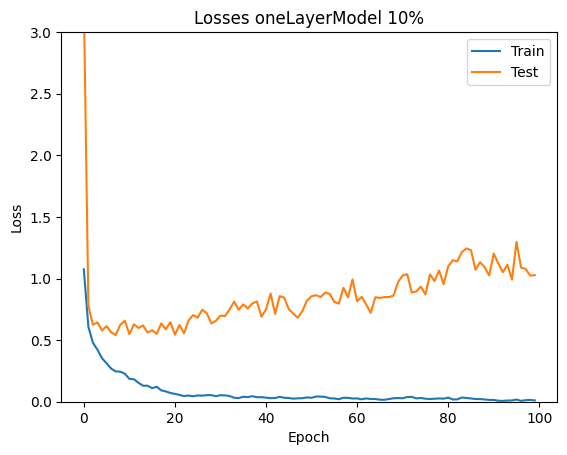

In [9]:
print('oneLayerModel 10%')
oneLayerModel_losses_10 = train(
    model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)
evaluate_model(model, test_loader)
plot_loss(oneLayerModel_losses_10, 'Losses oneLayerModel 10%')